In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_sin_moving_window_data(
    a: float,
    b: float,
    dx: float,
    L1: float,
    n_extra: int,
    k_step: int,
    funtion
):
    """
    Generate 3 datasets from y = sin(x) on [a, b].

    Parameters
    ----------
    a, b : float
        Domain interval [a, b].
    dx : float
        Step size of the major mesh.
    L1 : float
        Target length of learning window 1 (approx, snapped to grid).
    n_extra : int
        L2 = L1 + n_extra * dx, so window 2 is longer by n_extra grid cells.
    k_step : int
        Window shift in units of the major grid step (moving step = k_step * dx).

    Returns
    -------
    set1 : dict
        {
            "X": X_major,  # [N_major, 1] global coordinates
            "Y": Y_major   # [N_major, 1] sin(X_major)
        }

    set2 : dict  learning window 
        {
            "X_local":  Xw1_local,   # [B, Nw1, 1]
            "X_global": Xw1_global,  # [B, Nw1, 1]
            "Y":        Yw1          # [B, Nw1, 1] = sin(Xw1_global)
        }

    set3 : dict  prediction window
            "X_local":  Xw1_local,   # [B, Nw2, 1]
            "X_global": Xw1_global,  # [B, Nw2, 1]
            "Y":        Yw1          # [B, Nw2, 1] = sin(Xw1_global)
    """

    if b <= a:
        raise ValueError("Require b > a for a non-empty domain [a,b].")

    # ---------------------------------------------------------
    # 1. Build major mesh on [a, b]
    # ---------------------------------------------------------
    D = b - a
    N_major = int(round(D / dx)) + 1  # include both endpoints
    X_major = a + dx * np.arange(N_major)  # [N_major]
    Y_major = funtion(X_major)

    # Reshape for Set 1: [N1_point, coords] with coords=1
    X_major_2d = X_major.reshape(-1, 1)  # [N_major, 1]
    Y_major_2d = Y_major.reshape(-1, 1)  # [N_major, 1]

    # ---------------------------------------------------------
    # 2. Define window sizes in terms of number of points
    # ---------------------------------------------------------
    # Snap L1 to integer number of dx steps.
    Nw1 = int(round(L1 / dx)) + 1  # Nw1 points => (Nw1-1)*dx approximate length
    if Nw1 < 2:
        raise ValueError("Window 1 must contain at least 2 points.")

    # Window 2 is longer by n_extra cells
    Nw2 = Nw1 + n_extra
    if Nw2 < 2:
        raise ValueError("Window 2 must contain at least 2 points.")

    L1_eff = (Nw1 - 1) * dx
    L2_eff = (Nw2 - 1) * dx

    if L1_eff >= D or L2_eff >= D:
        raise ValueError("Window lengths must be smaller than domain length D = b - a.")

    # ---------------------------------------------------------
    # 3. Compute all valid window starting indices
    # ---------------------------------------------------------
    # Both windows move together, so they must both fit when starting at i0.
    max_start_index = N_major - Nw2  # inclusive
    if max_start_index < 0:
        raise ValueError("Domain too small for selected window 2 length.")

    # Starting indices: 0, k_step, 2*k_step, ..., <= max_start_index
    start_indices = np.arange(0, max_start_index + 1, k_step, dtype=int)
    B = len(start_indices)  # number of batches (window positions)
    print(f"start_indices: {start_indices}")

    if B == 0:
        raise ValueError("No valid window positions. Try smaller k_step or windows.")

    # ---------------------------------------------------------
    # 4. Collect data for window 1 and window 2 at each position
    # ---------------------------------------------------------
    Xw1_local_list = []
    Xw1_global_list = []
    Yw1_list = []

    Xw2_local_list = []
    Xw2_global_list = []
    Yw2_list = []

    for i0 in start_indices:
        print(f"Processing window starting at major index i0 = {i0}")
        # Window 1 indices: contiguous segment of length Nw1
        idx1 = np.arange(i0, i0 + Nw1)
        # Window 2 indices: contiguous segment of length Nw2
        idx2 = np.arange(i0, i0 + Nw2)

        # --- Window 1 ---
        xw1_global = X_major[idx1]               # [Nw1]
        xw1_local = xw1_global - xw1_global[0]   # [0, L1_eff]
        yw1 = funtion(xw1_global)                # [Nw1]

        Xw1_global_list.append(xw1_global)
        Xw1_local_list.append(xw1_local)
        Yw1_list.append(yw1)

        # --- Window 2 ---
        xw2_global = X_major[idx2]               # [Nw2]
        xw2_local = xw2_global - xw2_global[0]   # [0, L2_eff]
        yw2 = funtion(xw2_global)

        Xw2_global_list.append(xw2_global)
        Xw2_local_list.append(xw2_local)
        Yw2_list.append(yw2)

    # Stack into arrays: [B, Nw*, 1]
    Xw1_local = np.stack(Xw1_local_list, axis=0)[..., np.newaxis]
    Xw1_global = np.stack(Xw1_global_list, axis=0)[..., np.newaxis]
    Yw1 = np.stack(Yw1_list, axis=0)[..., np.newaxis]

    Xw2_local = np.stack(Xw2_local_list, axis=0)[..., np.newaxis]
    Xw2_global = np.stack(Xw2_global_list, axis=0)[..., np.newaxis]
    Yw2 = np.stack(Yw2_list, axis=0)[..., np.newaxis]

    # ---------------------------------------------------------
    # 5. Pack into the 3 requested sets
    # ---------------------------------------------------------
    set1 = {
        "X": X_major_2d,  # [N_major, 1]
        "Y": Y_major_2d,  # [N_major, 1]
    }

    set2 = {
        "X_local": Xw1_local,    # [B, Nw1, 1]
        "X_global": Xw1_global,  # [B, Nw1, 1]
        "Y": Yw1,                # [B, Nw1, 1]
    }

    set3 = {
        "X_local": Xw2_local,    # [B, Nw2, 1]
        "X_global": Xw2_global,  # [B, Nw2, 1]
        "Y": Yw2,                # [B, Nw2, 1]
    }

    return set1, set2, set3


# ---------------------------------------------------------------------
# Plotting functions
# ---------------------------------------------------------------------

def plot_all_sets(set1, set2, set3, max_batches: int = 5):
    """
    Make 3 figures:
    - Fig 1: major mesh (set1)
    - Fig 2: window 1 (set2): global & local
    - Fig 3: window 2 (set3): global & local

    max_batches: how many window positions to show (to avoid overcrowding).
    """

    # ---------------- Fig 1: Set 1 (major mesh) ----------------
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    x1 = set1["X"][:, 0]
    y1 = set1["Y"][:, 0]
    ax1.plot(x1, y1, label="sin(x)")
    ax1.set_title("Set 1: Major Mesh")
    ax1.set_xlabel("x (global)")
    ax1.set_ylabel("y = sin(x)")
    ax1.grid(True)
    ax1.legend()

    # ---------------- Fig 2: Set 2 (window 1) ----------------
    Xw1_local = set2["X_local"]   # [B, Nw1, 1]
    Xw1_global = set2["X_global"] # [B, Nw1, 1]
    Yw1 = set2["Y"]               # [B, Nw1, 1]
    B1 = Xw1_global.shape[0]
    nb_plot = min(B1, max_batches)

    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig2.suptitle("Set 2: Window 1")

    # Global coordinates
    for b in range(nb_plot):
        xg = Xw1_global[b, :, 0]
        yg = Yw1[b, :, 0]
        label = f"batch {b}" 
        ax2a.plot(xg, yg, marker="o", linestyle="-", alpha=0.7, label=label)
    ax2a.set_xlabel("x (global)")
    ax2a.set_ylabel("y = sin(x)")
    ax2a.set_title("Global coords")
    ax2a.grid(True)
    if nb_plot <10:
        ax2a.legend()

    # Local coordinates
    for b in range(nb_plot):
        xl = Xw1_local[b, :, 0]
        yl = Yw1[b, :, 0]
        label = f"batch {b}" 
        ax2b.plot(xl, yl, marker="o", linestyle="-", alpha=0.7, label=label)
    ax2b.set_xlabel("x_local")
    ax2b.set_title("Local coords")
    ax2b.grid(True)
    if nb_plot < 10:
        ax2b.legend()

    # ---------------- Fig 3: Set 3 (window 2) ----------------
    Xw2_local = set3["X_local"]   # [B, Nw2, 1]
    Xw2_global = set3["X_global"] # [B, Nw2, 1]
    Yw2 = set3["Y"]               # [B, Nw2, 1]
    B2 = Xw2_global.shape[0]
    nb_plot2 = min(B2, max_batches)

    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig3.suptitle("Set 3: Window 2")

    # Global
    for b in range(nb_plot2):
        xg = Xw2_global[b, :, 0]
        yg = Yw2[b, :, 0]
        label = f"batch {b}" 
        ax3a.plot(xg, yg, marker="o", linestyle="-", alpha=0.7, label=label)
    ax3a.set_xlabel("x (global)")
    ax3a.set_ylabel("y = sin(x)")
    ax3a.set_title("Global coords")
    ax3a.grid(True)
    if nb_plot < 10:
        ax3a.legend()

    # Local
    for b in range(nb_plot2):
        xl = Xw2_local[b, :, 0]
        yl = Yw2[b, :, 0]
        label = f"batch {b}" 
        ax3b.plot(xl, yl, marker="o", linestyle="-", alpha=0.7, label=label)
    ax3b.set_xlabel("x_local")
    ax3b.set_title("Local coords")
    ax3b.grid(True)
    if nb_plot < 10:
        ax3b.legend()

    plt.tight_layout()
    return fig1, fig2, fig3


# ---------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------
if __name__ == "__main__":
    from pathlib import Path
    out_npz = "./data/train_sin_moving_window_data.npz"
    funtion_lf = np.sin
    funtion_hf = lambda x: 0.5*np.sin(x) + 5
    dx_ratio = 1/100 


    # Train HF Domain [a, b]
    lb_hf = 0.0
    ub_hf = 4.0 * np.pi
    # Train LF Domain [a, b]
    lb_lf = 0.0
    ub_lf = 12.0 * np.pi
    kwd=5               # length of window 1 in unit of dx       
    n_extra = 5      # window 2 is longer by n_extra * dx
    moving_step = 1       # move windows by 3*dx each time

    L_lf= ub_lf-lb_lf
    L_hf= ub_hf-lb_hf
    dx = dx_ratio * L_lf
    Lw = kwd*dx         # length of window 1 (approx, snapped to grid)
    # Extrapolation Domain [a, b]
    lb_extr = ub_hf- Lw
    ub_extr= ub_lf
    #--------
    L_extra= ub_extr-lb_extr

    # generate LF full main domain
    set_LF_full_global, set_LF_full_learn_wd, set_LF_full_prd_wd = generate_sin_moving_window_data(lb_lf, ub_lf, dx, Lw, n_extra, moving_step,funtion=funtion_lf)
    # generate HF full main domain
    set_HF_full_global, set_HF_full_learn_wd, set_HF_full_prd_wd = generate_sin_moving_window_data(lb_lf, ub_lf, dx, Lw, n_extra, moving_step,funtion=funtion_hf)
    #--------
    # generate LF train domain
    set_LF_train_global, set_LF_train_learn_wd,set_LF_train_prd_wd = generate_sin_moving_window_data(lb_hf, ub_hf, dx, Lw, n_extra, moving_step,funtion=funtion_lf)
    # generate HF train domain
    set_HF_train_global, set_HF_train_learn_wd, set_HF_train_prd_wd = generate_sin_moving_window_data(lb_hf, ub_hf, dx, Lw, n_extra, moving_step,funtion=funtion_hf)
    #--------
    # generate LF extra domain
    set_LF_extra_global, set_LF_extr_learn_wd,set_LF_extra_prd_wd = generate_sin_moving_window_data(lb_extr, ub_extr, dx, Lw, n_extra, moving_step,funtion=funtion_lf)
    # generate HF extra domain
    set_HF_extra_global, set_HF_extra_learn_wd, set_HF_extra_prd_wd = generate_sin_moving_window_data(lb_extr, ub_extr, dx, Lw, n_extra, moving_step,funtion=funtion_hf)

    y_lf_br1 = set_LF_full_global["Y"].T    #  [1,N_LF]
    y_hf_br2 = set_HF_train_global["Y"].T   # [1,N_HF]
    Y_lf_learn_wd_br3 = set_LF_train_learn_wd["Y"].squeeze(-1)     # [B,Nw1]
    Y_hf_learn_wd_br4 = set_HF_train_learn_wd["Y"].squeeze(-1)     # [B,Nw1,1]
    X_prd_train_coord_t  = set_HF_train_prd_wd["X_local"]   # [B,Nw1,1]
    Y_HF_train_out = set_HF_train_prd_wd["Y"].squeeze(-1)   # [B,Nw1,1]
    #--------
    Y_lf_extra_wd_br3 = set_LF_extr_learn_wd["Y"].squeeze(-1)     # [B,Nw1]
    Y_hf_extra_wd_br4 = set_HF_extra_learn_wd["Y"].squeeze(-1)     # [B,Nw1,1]
    X_prd_extra_coord_t  = set_HF_extra_prd_wd["X_local"]    # [B,Nw1,1]
    X_prd_extra_coord_t_global  = set_HF_extra_prd_wd["X_global"]    # [B,Nw1,1]
    Y_HF_extra_out = set_HF_extra_prd_wd["Y"].squeeze(-1)    # [B,Nw1,1]

    print("y_lf_br1:", y_lf_br1.shape)
    print("y_hf_br2:", y_hf_br2.shape)
    print("Y_lf_learn_wd_br3:", Y_lf_learn_wd_br3.shape)
    print("Y_hf_learn_wd_br4:", Y_hf_learn_wd_br4.shape)
    print("X_prd_train_coord_t:", X_prd_train_coord_t.shape)
    print("Y_HF_train_out:", Y_HF_train_out.shape)
    print("Y_lf_extra_wd_br3:", Y_lf_extra_wd_br3.shape)
    print("Y_hf_extra_wd_br4:", Y_hf_extra_wd_br4.shape)
    print("X_prd_extra_coord_t:", X_prd_extra_coord_t.shape)

    print("Y_HF_extra_out:", Y_HF_extra_out.shape)


    Path(out_npz).parent.mkdir(parents=True, exist_ok=True)

    save_dict = dict(
        y_lf_br1 = y_lf_br1 ,
        y_hf_br2 = y_hf_br2 ,
        Y_lf_learn_wd_br3 =  Y_lf_learn_wd_br3 ,
        Y_hf_learn_wd_br4 =  Y_hf_learn_wd_br4,
        X_prd_train_coord_t = X_prd_train_coord_t ,
        Y_HF_train_out = Y_HF_train_out ,
        Y_lf_extra_wd_br3 =  Y_lf_extra_wd_br3 ,
        Y_hf_extra_wd_br4 =  Y_hf_extra_wd_br4,
        X_prd_extra_coord_t = X_prd_extra_coord_t ,
        X_prd_extra_coord_t_global = X_prd_extra_coord_t_global ,
        Y_HF_extra_out = Y_HF_extra_out
        )
    np.savez_compressed(out_npz, **save_dict)
    print(f"[saved] {out_npz}")

    # Plot everything
    fig1, fig2, fig3 = plot_all_sets(set_HF_full_global, set_HF_full_learn_wd, set_HF_full_prd_wd, max_batches=100)
    plt.show()
    fig1, fig2, fig3 = plot_all_sets(set_HF_train_global, set_HF_train_learn_wd, set_HF_train_prd_wd, max_batches=100)
    plt.show()
    fig1, fig2, fig3 = plot_all_sets(set_HF_extra_global, set_HF_extra_learn_wd, set_HF_extra_prd_wd, max_batches=100)
    plt.show()

    # # ==== SAVE FIGURES AS PNG FILES ====
    # fig1.savefig("fig1_set1.png", dpi=300, bbox_inches="tight")
    # fig2.savefig("fig2_set2.png", dpi=300, bbox_inches="tight")
    # fig3.savefig("fig3_set3.png", dpi=300, bbox_inches="tight")

    # Optional: still show on screen



/data3/vinh/Project/Turbulence_modeling/FHIT_case/src/Ongoing/MDE/eval_model.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_loca

Loaded model from: mb_deeponet_checkpoints/multibranch_deeponet_best.pt
Model config: {'b1_dim': 101, 'b2_dim': 34, 'b3_dim': 6, 'trunk_in_dim': 1, 'width': 64, 'branch_hidden': (128, 128), 'trunk_hidden': (128, 128)}
Device: cuda
  y_lf_br1            : (1, 101)
  y_hf_br2            : (1, 34)
  Y_lf_extra_wd_br3   : (63, 6)
  Y_hf_extra_wd_br4   : (63, 6)
  X_prd_extra_coord_t : (63, 11, 1)
  Y_HF_extra_out      : (63, 11)
batch size: 63
Y_hf_extra_wd_br4 window shape: torch.Size([1, 6])
X_prd_extra_coord_t_tensor shape: torch.Size([1, 11, 1])
Y_hf_extra_wd_br4 window shape: torch.Size([1, 6])
X_prd_extra_coord_t_tensor shape: torch.Size([1, 11, 1])
Y_hf_extra_wd_br4 window shape: torch.Size([1, 6])
X_prd_extra_coord_t_tensor shape: torch.Size([1, 11, 1])
Y_hf_extra_wd_br4 window shape: torch.Size([1, 6])
X_prd_extra_coord_t_tensor shape: torch.Size([1, 11, 1])
Y_hf_extra_wd_br4 window shape: torch.Size([1, 6])
X_prd_extra_coord_t_tensor shape: torch.Size([1, 11, 1])
Y_hf_extra_wd_br

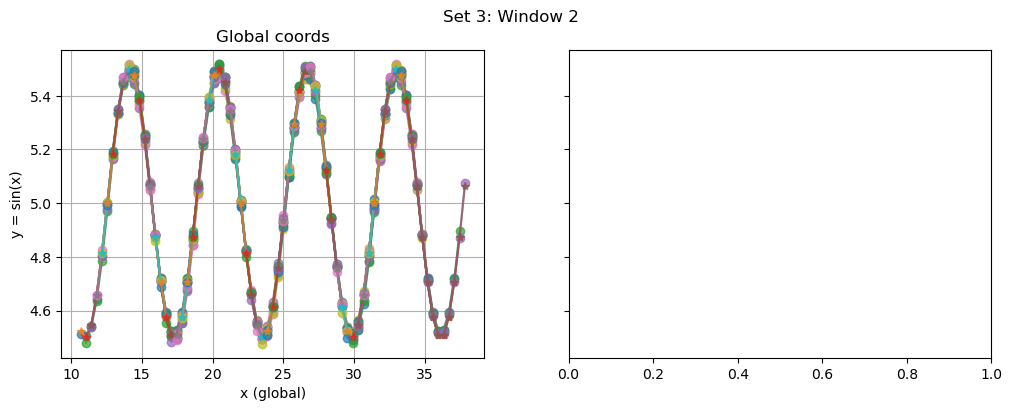

In [1]:
import torch
import numpy as np
from eval_model import load_model
import matplotlib.pyplot as plt


# -------------------------------------------------
# 1. Load trained model
# -------------------------------------------------
checkpoint = "mb_deeponet_checkpoints/multibranch_deeponet_best.pt"
model, cfg, dev = load_model(checkpoint)

kwd = 5          # length of window 1 in unit of dx
n_extra = 5      # window 2 is longer by n_extra * dx (currently unused)
moving_step = 1  # move windows by moving_step * dx each time

# -------------------------------------------------
# 2. Load data
# -------------------------------------------------
val_npz = "data/train_sin_moving_window_data.npz"
val = np.load(val_npz)

y_lf_br1            = val["y_lf_br1"]             # [1, Nb1]
y_hf_br2            = val["y_hf_br2"]             # [1, Nb2]
Y_lf_extra_wd_br3   = val["Y_lf_extra_wd_br3"]    # [B, Nw1]
Y_hf_extra_wd_br4   = val["Y_hf_extra_wd_br4"]    # [B, Nw1]
X_prd_extra_coord_t = val["X_prd_extra_coord_t"]  # [B, Nt, 1]
X_prd_extra_coord_t_global = val["X_prd_extra_coord_t_global"]  # [B, Nt, 1]
Y_HF_extra_out      = val["Y_HF_extra_out"]       # [B, Nt]

print(f"  y_lf_br1            : {y_lf_br1.shape}")
print(f"  y_hf_br2            : {y_hf_br2.shape}")
print(f"  Y_lf_extra_wd_br3   : {Y_lf_extra_wd_br3.shape}")
print(f"  Y_hf_extra_wd_br4   : {Y_hf_extra_wd_br4.shape}")
print(f"  X_prd_extra_coord_t : {X_prd_extra_coord_t.shape}")
print(f"  Y_HF_extra_out      : {Y_HF_extra_out.shape}")

# -------------------------------------------------
# 3. Convert to tensors (fixed inputs)
# -------------------------------------------------
y_lf_br1_tensor = torch.as_tensor(y_lf_br1, dtype=torch.float32, device=dev)  # [1, Nb1]

y_hf_br2_tensor = torch.as_tensor(y_hf_br2, dtype=torch.float32, device=dev)  # [1, Nb2]

Y_lf_extra_wd_br3_tensor = torch.as_tensor(Y_lf_extra_wd_br3, dtype=torch.float32, device=dev)  # [B, Nw1]

# HF window kept as NumPy array for easy concatenation
Y_hf_extra_wd_br4_np = Y_hf_extra_wd_br4.copy()    # [B, Nw1]

X_prd_extra_coord_t_tensor = torch.as_tensor(X_prd_extra_coord_t, dtype=torch.float32, device=dev)  # [B, Nt, 1]

Y_HF_extra_out_tensor = torch.as_tensor(Y_HF_extra_out, dtype=torch.float32, device=dev)  # [B, Nt]

# Container for predictions (NumPy)
Y_HF_extra_pred = np.zeros_like(Y_HF_extra_out, dtype=np.float32)

B, Nt, _ = X_prd_extra_coord_t_tensor.shape
print("batch size:", B)

# -------------------------------------------------
# 4. Autoregressive loop over batch
# -------------------------------------------------
Y_hf_window_np = None  # current HF window [1, Nw1]

for i in range(B):
    # Slice current sample
    x_i = X_prd_extra_coord_t_tensor[i:i+1, :, :]      # [1, Nt, 1]
    u3_i = Y_lf_extra_wd_br3_tensor[i:i+1, :]          # [1, Nw1]

    if i == 0:
        # Start from true HF window for sample 0
        Y_hf_window_np = Y_hf_extra_wd_br4_np[i:i+1, :]  # [1, Nw1]
    # else: use updated Y_hf_window_np from previous iteration

    u4_i = torch.as_tensor(Y_hf_window_np, dtype=torch.float32, device=dev)  # [1, Nw1]

    print("Y_hf_extra_wd_br4 window shape:", u4_i.shape)
    print("X_prd_extra_coord_t_tensor shape:", x_i.shape)

    # Forward pass
    with torch.no_grad():
        y_pred = model(
            y_lf_br1_tensor,  # [1, Nb1]
            y_hf_br2_tensor,  # [1, Nb2]
            u3_i,             # [1, Nw1]
            u4_i,             # [1, Nw1]
            x_i,              # [1, Nt, 1]
        )                     # -> [1, Nt]

    y_pred_np = y_pred.detach().cpu().numpy()  # [1, Nt]

    # Save full predicted field for this sample
    Y_HF_extra_pred[i, :] = y_pred_np[0, :]

    # ---- Update HF window for next iteration ----
    # predicted segment at [kwd : kwd + moving_step]
    y_add = y_pred_np[:, kwd:kwd + moving_step]               # [1, moving_step]

    # base window: original HF window of sample i, shifted by moving_step
    base = Y_hf_extra_wd_br4_np[i:i+1, moving_step:]          # [1, Nw1 - moving_step]

    # new current HF window for next sample
    Y_hf_window_np = np.concatenate([base, y_add], axis=1)    # [1, Nw1]

# -------------------------------------------------
# 5. Optional: convert predictions to tensor & compute error
# -------------------------------------------------
Y_HF_extra_pred_tensor = torch.as_tensor(
    Y_HF_extra_pred, dtype=torch.float32, device=dev
)  # [B, Nt]

mse = torch.mean((Y_HF_extra_pred_tensor - Y_HF_extra_out_tensor) ** 2)
rmse = torch.sqrt(mse)
rel_l2 = torch.norm(
    Y_HF_extra_pred_tensor - Y_HF_extra_out_tensor
) / torch.norm(Y_HF_extra_out_tensor)

print("Prediction shape:", Y_HF_extra_pred.shape)
print("MSE :", mse.item())
print("RMSE:", rmse.item())
print("Rel L2:", rel_l2.item())

fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig3.suptitle("Set 3: Window 2")

import matplotlib.pyplot as plt
Xw_exptra_global = X_prd_extra_coord_t_global #set_HF_extra_prd_wd["X_global"] # [B, Nw2, 1]

B = Xw_exptra_global.shape[0]
# Global
for b in range(B):
    xg = Xw_exptra_global[b, :, 0]
    y_pred = Y_HF_extra_pred_tensor[b, :].detach().cpu().numpy()
    y_val = Y_HF_extra_out_tensor[b, :].detach().cpu().numpy()

    label = f"batch {b}" 
    ax3a.plot(xg, y_pred, marker="o", linestyle="-", alpha=0.7, label=label)
    ax3a.plot(xg, y_val, marker="*", linestyle="-", alpha=0.7, label=label)

ax3a.set_xlabel("x (global)")
ax3a.set_ylabel("y = sin(x)")
ax3a.set_title("Global coords")
ax3a.grid(True)
if b < 10:
    ax3a.legend()
